In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
DOWNLOAD_PATH = "./data/temp/"
DATA_PATH = "./data"
ZIP_NAME = "fer2013.zip"
TEMP_ZIP_FILE_PATH = os.path.join(DOWNLOAD_PATH, ZIP_NAME)
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [3]:
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

!curl -L -o {TEMP_ZIP_FILE_PATH} https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

with zipfile.ZipFile(TEMP_ZIP_FILE_PATH, "r") as zip:
    zip.extractall(DATA_PATH)

os.remove(TEMP_ZIP_FILE_PATH)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  3821k      0  0:00:16  0:00:16 --:--:-- 4173k


In [3]:
def load_dataset(PATH):
    CLASS_NAMES = sorted(os.listdir(PATH))
    CLASS_NAMES.remove("disgust")
    LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    
    images = []
    labels = []
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(PATH, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(LABEL_MAP[class_name])
    images = np.array(images)
    labels = np.array(labels)
    images, labels = shuffle(images, labels, random_state=42)
    return images, labels, LABEL_MAP

In [4]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28273, 48, 48, 3),
 (28273,),
 {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5})

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

def create_cnn_model(base_model, OUTPUT_SIZE):
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(OUTPUT_SIZE, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

2025-08-14 20:04:48.405413: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 20:04:48.456429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 20:04:49.802886: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [21]:
import os
import matplotlib.pyplot as plt

def show_train_loss_accuracy(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(history.history['loss'], label='Loss Treino')
    axes[0].plot(history.history['val_loss'], label='Loss Validação')
    axes[0].set_title(f'Loss - {model_name}')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Acurácia Treino')
        axes[1].plot(history.history['val_accuracy'], label='Acurácia Validação')
        axes[1].set_title(f'Acurácia - {model_name}')
        axes[1].set_xlabel('Época')
        axes[1].set_ylabel('Acurácia')
        axes[1].legend()
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'Acurácia não disponível', ha='center', va='center')

    plt.tight_layout()

    save_dir = os.path.join(model_name, "metrics", "training")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "accuracy_loss_plot_basic_sem_nojo.png")
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


In [7]:
from tensorflow.keras.applications import VGG19, DenseNet201, ResNet50V2

OUTPUT_CLASSES = 6
INPUT_SHAPE = (48, 48, 3)

def get_callbacks(model_name):
    return [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint(f'{model_name}/best_{model_name}_no_disgust.keras', monitor='accuracy', save_best_only=True)
]


resnet50v2 = create_cnn_model(
    ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

denseNet201 = create_cnn_model(DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

vgg19 = create_cnn_model(VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES)

models = {
    "ResNet50v2": resnet50v2,
    "DenseNet201": denseNet201,
    "VGG19": vgg19,
    
}

2025-08-14 20:04:50.049396: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

BATCH_SIZE = 32
EPOCHS = 60
histories = {}

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)

for model_name, model in models.items():
    print(f"STRAT TRAINING MODEL {model_name}...")
    histories[model_name] = model.fit(X_train_resized, y_train_cat,
                                     validation_split=0.2,
                                     epochs=EPOCHS,
                                     batch_size=BATCH_SIZE,
                                     callbacks=get_callbacks(model_name))
    print(f"FINISH TRAINING MODEL {model_name}!")
    print("---------------------------------------------------------------")

STRAT TRAINING MODEL ResNet50v2...
Epoch 1/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 73s 95ms/step - accuracy: 0.2303 - loss: 2.6837 - val_accuracy: 0.2865 - val_loss: 1.8609 - learning_rate: 1.0000e-04
Epoch 2/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 88s 124ms/step - accuracy: 0.2811 - loss: 2.1103 - val_accuracy: 0.3266 - val_loss: 1.7200 - learning_rate: 1.0000e-04
Epoch 3/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 92s 130ms/step - accuracy: 0.3104 - loss: 1.8819 - val_accuracy: 0.3469 - val_loss: 1.6562 - learning_rate: 1.0000e-04
Epoch 4/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 91s 129ms/step - accuracy: 0.3369 - loss: 1.7649 - val_accuracy: 0.3547 - val_loss: 1.6162 - learning_rate: 1.0000e-04
Epoch 5/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 89s 126ms/step - accuracy: 0.3518 - loss: 1.6856 - val_accuracy: 0.3492 - val_loss: 1.6023 - learning_rate: 1.0000e-04
Epoch 6/60
707/707 ━━━━━━━━━━━━━━━━━━━━ 91s 129ms/step - accuracy: 0.3659 - loss: 1.6300 - val_accuracy: 0.3641 - val_loss: 1.5727 - learning_rate: 1.0000e-04
Epoch 7/60
7

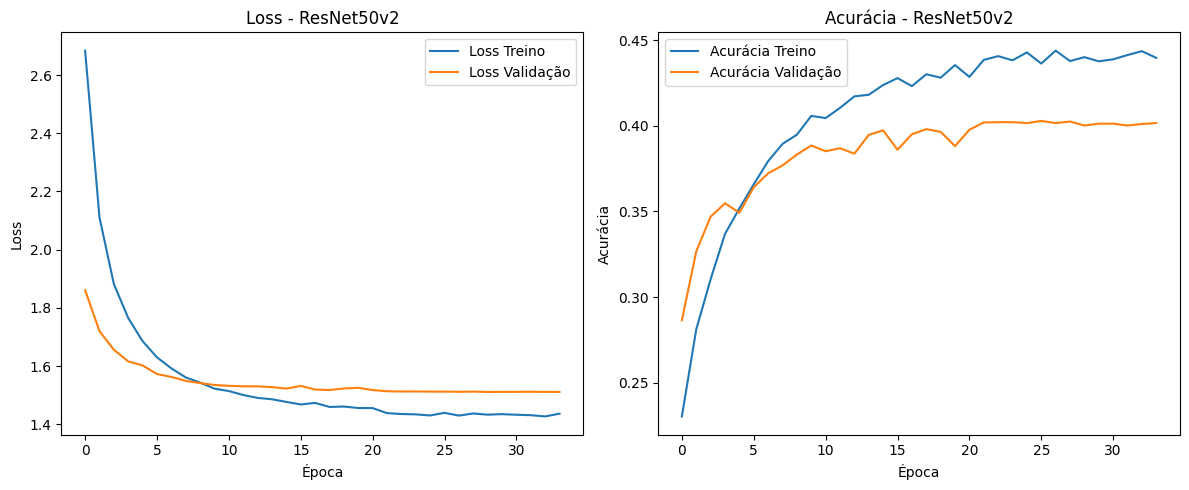

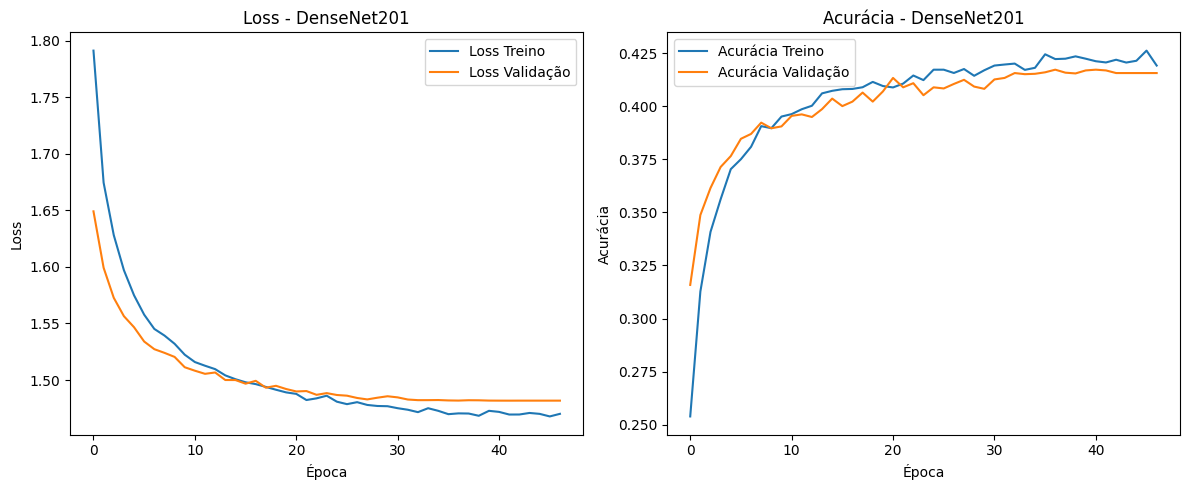

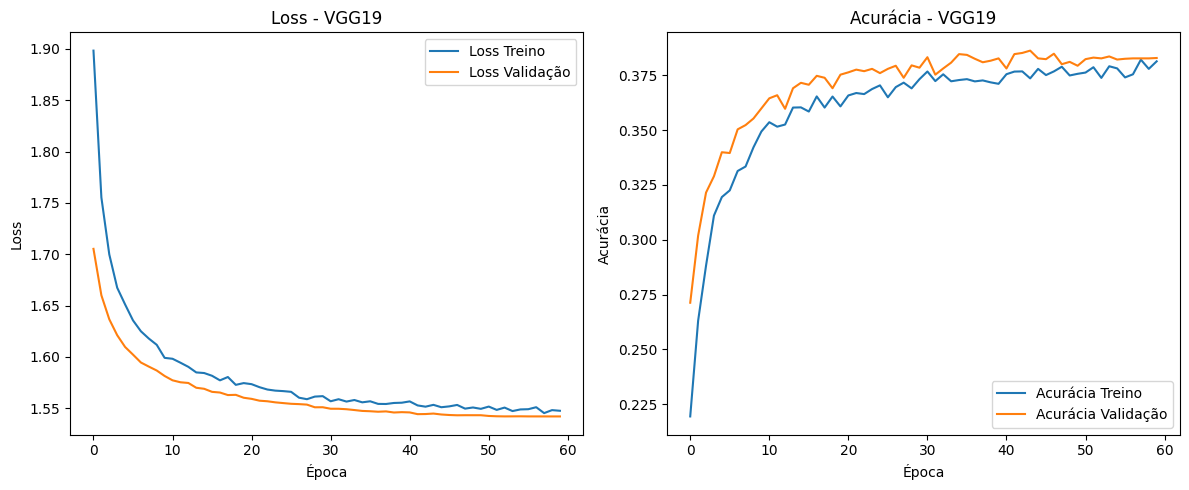

In [22]:
for model_name, history in histories.items():
    show_train_loss_accuracy(history, model_name)

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

def show_metrics(y_true, y_pred, model_name, is_test=False):
    classes_emocao = list(LABEL_MAP.keys())
    class_acc = {}

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Métricas do modelo: {model_name}")
    print("Accuracy Score:  ", round(acc, 4))
    print("Precision Score: ", round(prec, 4))
    print("Recall Score:    ", round(rec, 4))
    print("F1 Score:        ", round(f1, 4))
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))
    
    for i, emotion in enumerate(classes_emocao):
        idx = np.where(y_true == i)[0]
        correct = np.sum(y_pred[idx] == y_true[idx])
        class_acc[emotion] = correct / len(idx)
    
    print('\nAcurácia por classe:')
    for emotion, acc in class_acc.items():
        print(f'- {emotion}: {acc:.2%}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes_emocao, 
                yticklabels=classes_emocao)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

    save_dir = os.path.join(model_name, "metrics", "simple")
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f"{"test_" if is_test else "train_"}confusion_matrix_sem_nojo.jpg")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [11]:
def get_preds(X, model):
    y = model.predict(X)
    return np.argmax(y, axis=1)

In [12]:
y_preds = {}
for model_name, model in models.items():
    y_preds[model_name] = get_preds(X_train_resized, model)

2025-08-15 03:25:52.002568: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 781691904 exceeds 10% of free system memory.


884/884 ━━━━━━━━━━━━━━━━━━━━ 177s 198ms/step


2025-08-15 03:28:51.039936: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 781691904 exceeds 10% of free system memory.


884/884 ━━━━━━━━━━━━━━━━━━━━ 256s 280ms/step


2025-08-15 03:33:08.752720: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 781691904 exceeds 10% of free system memory.


884/884 ━━━━━━━━━━━━━━━━━━━━ 260s 294ms/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.4617
Precision Score:  0.4538
Recall Score:     0.4328
F1 Score:         0.4329

Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.27      0.33      3995
           1       0.40      0.25      0.31      4097
           2       0.48      0.74      0.59      7215
           3       0.44      0.39      0.41      4965
           4       0.42      0.40      0.41      4830
           5       0.55      0.54      0.55      3171

    accuracy                           0.46     28273
   macro avg       0.45      0.43      0.43     28273
weighted avg       0.45      0.46      0.45     28273


Acurácia por classe:
- angry: 26.96%
- fear: 25.41%
- happy: 74.16%
- neutral: 38.77%
- sad: 40.14%
- surprise: 54.24%


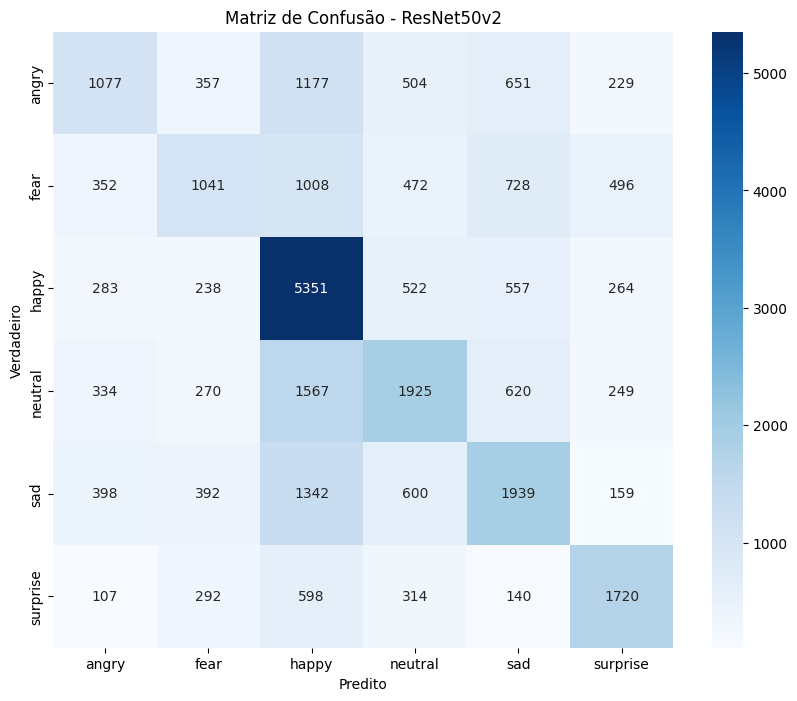

Métricas do modelo: DenseNet201
Accuracy Score:   0.4412
Precision Score:  0.4374
Recall Score:     0.4093
F1 Score:         0.4098

Classification Report:

              precision    recall  f1-score   support

           0       0.41      0.23      0.30      3995
           1       0.39      0.21      0.28      4097
           2       0.46      0.73      0.56      7215
           3       0.41      0.39      0.40      4965
           4       0.40      0.38      0.39      4830
           5       0.57      0.50      0.53      3171

    accuracy                           0.44     28273
   macro avg       0.44      0.41      0.41     28273
weighted avg       0.43      0.44      0.42     28273


Acurácia por classe:
- angry: 23.48%
- fear: 21.45%
- happy: 73.39%
- neutral: 38.87%
- sad: 37.89%
- surprise: 50.49%


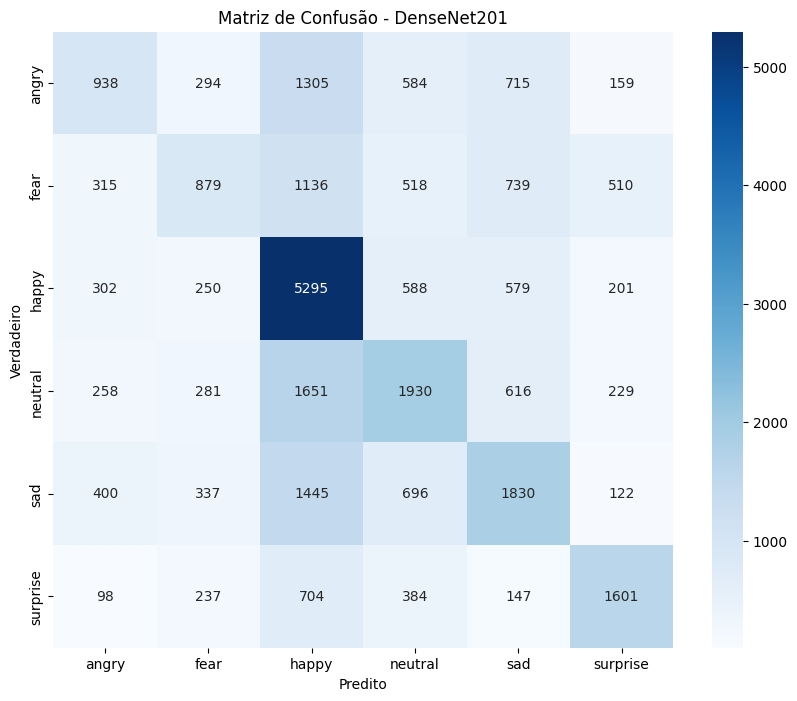

Métricas do modelo: VGG19
Accuracy Score:   0.3977
Precision Score:  0.3952
Recall Score:     0.3633
F1 Score:         0.3573

Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.15      0.21      3995
           1       0.38      0.16      0.23      4097
           2       0.41      0.72      0.52      7215
           3       0.37      0.32      0.34      4965
           4       0.35      0.35      0.35      4830
           5       0.51      0.48      0.49      3171

    accuracy                           0.40     28273
   macro avg       0.40      0.36      0.36     28273
weighted avg       0.39      0.40      0.37     28273


Acurácia por classe:
- angry: 14.77%
- fear: 16.18%
- happy: 71.70%
- neutral: 31.88%
- sad: 35.38%
- surprise: 48.09%


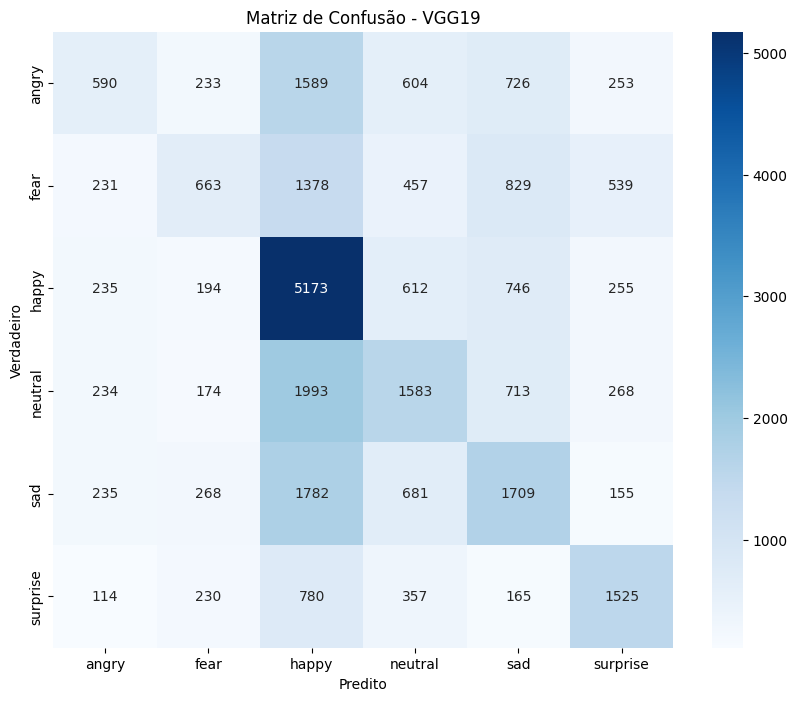

In [19]:
metrics = {}
for model_name, preds in y_preds.items():
    metrics[model_name] = show_metrics(y_train, preds, model_name)

In [14]:
y_preds_teste = {}
for model_name, model in models.items():
    y_preds_teste[model_name] = get_preds(X_test_resized, model)

221/221 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 76s 344ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 65s 292ms/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.419
Precision Score:  0.3998
Recall Score:     0.3892
F1 Score:         0.386

Classification Report:

              precision    recall  f1-score   support

           0       0.33      0.23      0.27       958
           1       0.32      0.20      0.25      1024
           2       0.47      0.71      0.57      1774
           3       0.38      0.33      0.36      1233
           4       0.37      0.35      0.36      1247
           5       0.52      0.51      0.52       831

    accuracy                           0.42      7067
   macro avg       0.40      0.39      0.39      7067
weighted avg       0.40      0.42      0.40      7067


Acurácia por classe:
- angry: 23.07%
- fear: 20.21%
- happy: 71.42%
- neutral: 33.09%
- sad: 34.96%
- surprise: 50.78%


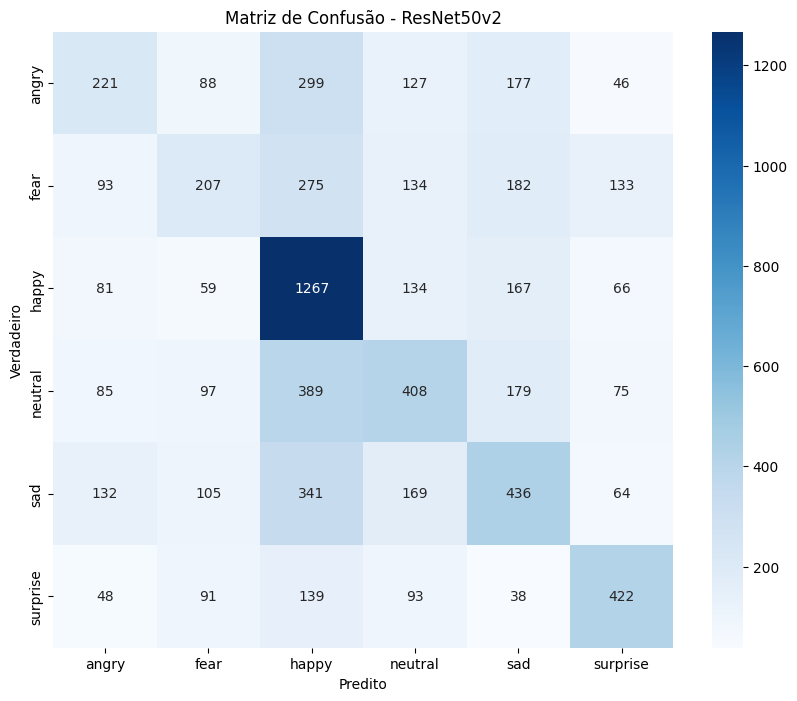

Métricas do modelo: DenseNet201
Accuracy Score:   0.4184
Precision Score:  0.4012
Recall Score:     0.3857
F1 Score:         0.3831

Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.19      0.23       958
           1       0.29      0.17      0.22      1024
           2       0.45      0.72      0.56      1774
           3       0.38      0.36      0.37      1233
           4       0.40      0.37      0.38      1247
           5       0.58      0.50      0.54       831

    accuracy                           0.42      7067
   macro avg       0.40      0.39      0.38      7067
weighted avg       0.40      0.42      0.40      7067


Acurácia por classe:
- angry: 18.89%
- fear: 17.38%
- happy: 71.98%
- neutral: 35.93%
- sad: 36.81%
- surprise: 50.42%


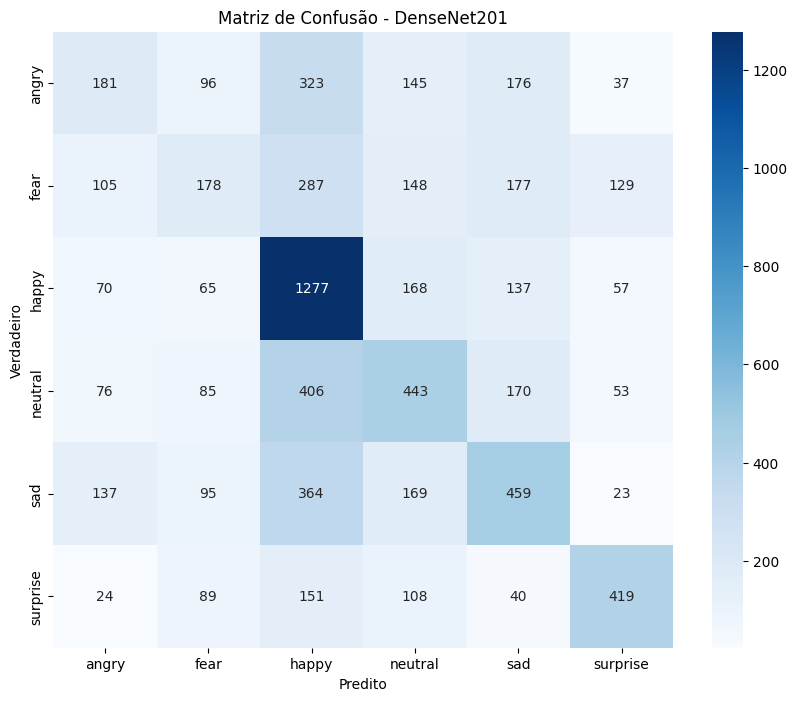

Métricas do modelo: VGG19
Accuracy Score:   0.3804
Precision Score:  0.3676
Recall Score:     0.3467
F1 Score:         0.3383

Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.13      0.18       958
           1       0.30      0.13      0.18      1024
           2       0.39      0.70      0.50      1774
           3       0.34      0.30      0.32      1233
           4       0.35      0.33      0.34      1247
           5       0.52      0.49      0.50       831

    accuracy                           0.38      7067
   macro avg       0.37      0.35      0.34      7067
weighted avg       0.37      0.38      0.35      7067


Acurácia por classe:
- angry: 13.05%
- fear: 12.70%
- happy: 69.67%
- neutral: 30.41%
- sad: 33.44%
- surprise: 48.74%


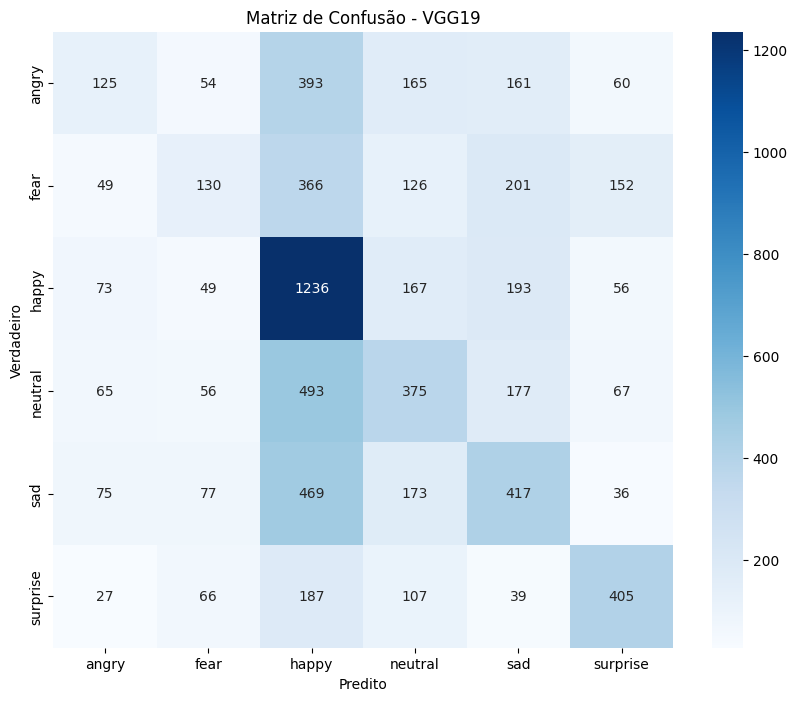

In [20]:
metrics_teste = {}
for model_name, preds in y_preds_teste.items():
    metrics_teste[model_name] = show_metrics(y_test, preds, model_name, is_test=True)